# Analysis for the paper 

## Import all the libraries

In [21]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from math import exp

from os import *
from os import listdir
from os.path import isfile, join

## Spike detection algorithm

In [2]:
# %load ./../functions/detect_peaks.py
"""Detect peaks in data based on their amplitude and other features."""

from __future__ import division, print_function
import numpy as np

__author__ = "Marcos Duarte, https://github.com/demotu/BMC"
__version__ = "1.0.5"
__license__ = "MIT"


def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height (if parameter
        `valley` is False) or peaks that are smaller than maximum peak height
         (if parameter `valley` is True).
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)

    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=-1.2, mpd=20, valley=True, show=True)

    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)

    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)

    Version history
    ---------------
    '1.0.5':
        The sign of `mph` is inverted if parameter `valley` is True
    
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
        if mph is not None:
            mph = -mph
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
            if mph is not None:
                mph = -mph
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind

## Generate plots

Read csv files generated with ImageJ after automatic segmentation of the red channel to define ROIs and normalize

In [31]:
#read csv files generated with ImageJ

mypath = 'test'

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

results = {}
for file in onlyfiles:
    if file.endswith('.csv'):
        results[path.splitext(file)[0]] = pd.read_csv(join(mypath,file), sep = ',')

#choose frame to normalize and get dF/F
frame = 100
results_norm={}
for file in results:
    norm = results[file].copy()
    for ex in np.arange(1,len(results[file].columns)):

        norm['Mean'+str(ex)] =  (norm['Mean'+str(ex)]-(np.mean(norm['Mean'+str(ex)][1:frame])))/np.mean(norm['Mean'+str(ex)][1:frame])
        results_norm[file+'_norm'] = norm.drop(' ', axis=1)


Plot traces

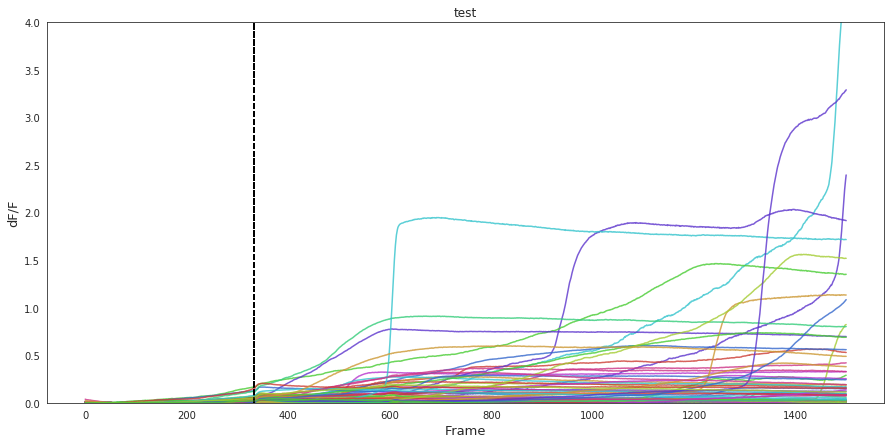

In [34]:

## Generate 

#style for plots


#set stimulation 
stim = 333

sns.set_style("white")
fig = plt.figure(figsize=(15, 7))
grid = plt.GridSpec(25, 2, wspace=0.2, hspace=3, figure = fig)
fig1 = fig.add_subplot(grid[:, :])
sub_fig = fig1

for file in results_norm:


    for ex in np.arange(1,len(results_norm[file].columns)):

        series = results_norm[file]['Mean'+str(ex)]
        cmap = sns.hls_palette(10,l=.5, s=.6)
        sns.set_palette(cmap)
        plt.plot(series, alpha = 0.8)
       
            #a = a+10
    
        plt.axvline(x = stim , linestyle = '--', color = 'black', alpha =0.7)
        plt.xlabel("Frame",fontdict={'fontsize':13})
        plt.ylabel("dF/F",fontdict={'fontsize':13})
        plt.title(mypath)
        sub_fig.set_ylim(0,4)


plt.show()




Plot heatmap with traces sorted by total GCaMP intensity

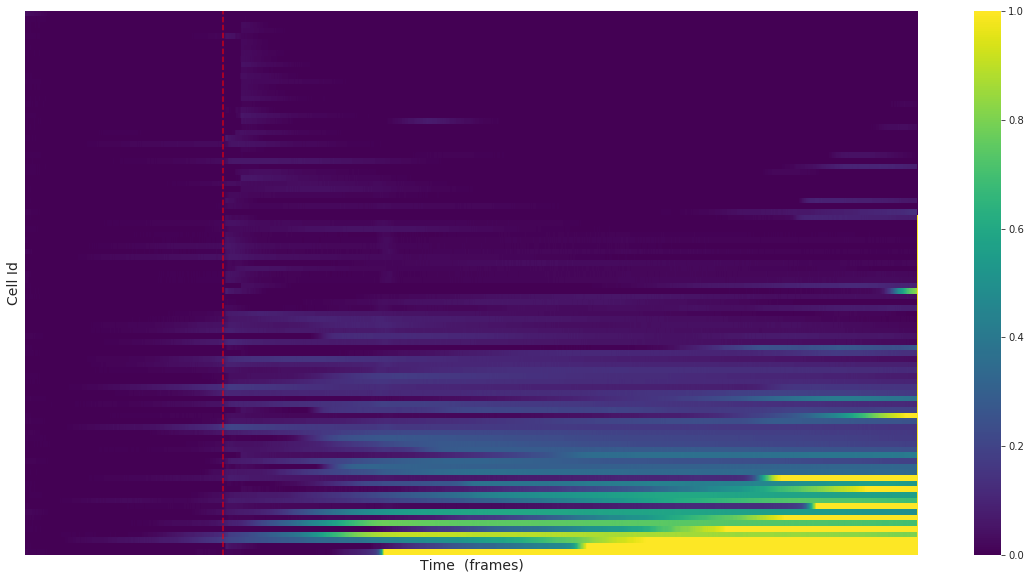

In [35]:

suma = []

for file in results_norm:
    suma.append(results_norm[file].T)
result = pd.concat(suma)

sns.set_style("white")
fig = plt.figure(figsize=(20, 10))
grid = plt.GridSpec(25, 2, wspace=0.2, hspace=3, figure = fig)
fig1 = fig.add_subplot(grid[:, :])
sub_fig = fig1

#Show heatmap sorted by total intensity
result['sum'] = result.sum(axis=1)

ax =sns.heatmap(result.sort_values(by="sum",ascending = 'True'),xticklabels = False,yticklabels = False ,vmin = 0, vmax = 1, cmap = 'viridis')
plt.xlabel('Time  (frames)', size = '14')
plt.ylabel('Cell Id',size = '14')
plt.axvline(x = stim , linestyle = '--', color = 'red', alpha =0.7)


## Detect spikes and generate stats (Method 1 - manually curated for false positives)

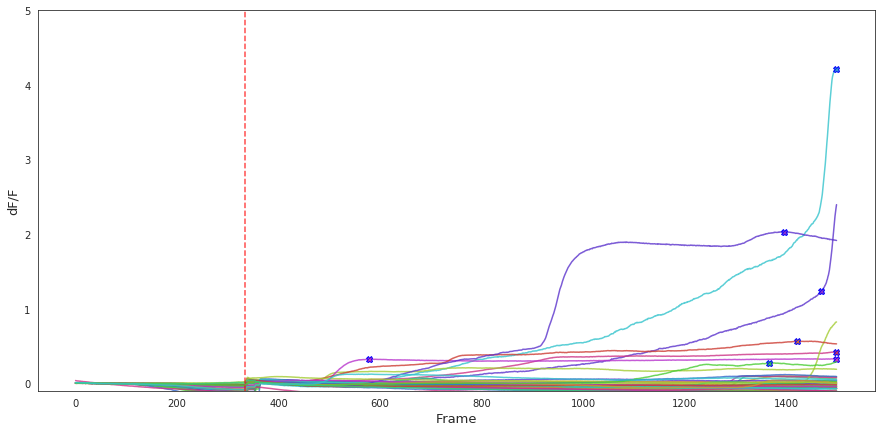

{'clone_id': 'test', 'positive': 8, 'total': 46, 'ratio': 0.17391304347826086}


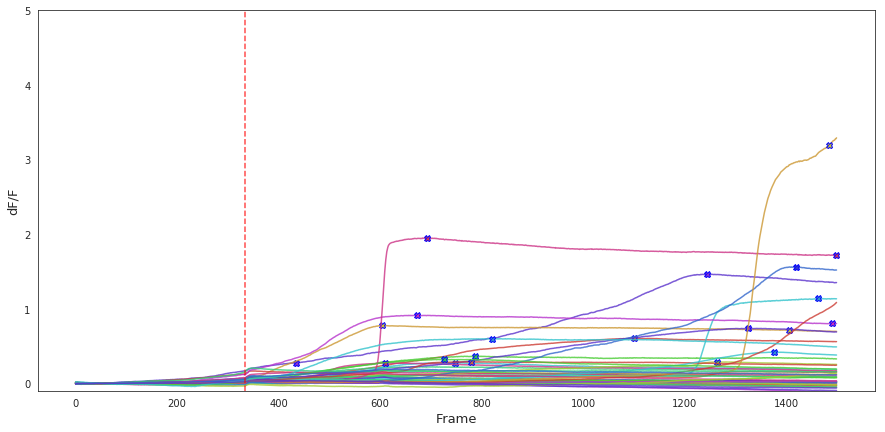

{'clone_id': 'test', 'positive': 21, 'total': 48, 'ratio': 0.4375}


In [16]:


for file in results_norm:
    
    #set style for plots
    sns.set_style("white")
    fig = plt.figure(figsize=(15, 7))
    grid = plt.GridSpec(25, 2, wspace=0.2, hspace=3, figure = fig)
    fig1 = fig.add_subplot(grid[:, :])
    sub_fig = fig1
    #initialize positive and total number of cells
    positive = 0
    total = 0
    for ex in np.arange(1,len(results_norm[file].columns)):
        series = results_norm[file]['Mean'+str(ex)]
        series_peaks =results_norm[file]['Mean'+str(ex)][stim:1500] 
        
        #set parameters for detect_peaks
        ind = detect_peaks(series_peaks, show=False,mph=0.25, mpd=800, threshold=0, edge='rising',kpsh=False)

        cmap = sns.hls_palette(20,l=.5, s=.6)
        sns.set_palette(cmap)
        plt.plot(series, alpha = 0.8)
        plt.xlabel("Frame",fontdict={'fontsize':13})
        plt.ylabel("dF/F",fontdict={'fontsize':13})
        sub_fig.set_ylim(-0.1,5)
        total = total + 1
        #plot detected peaks and count
        try:
                plt.plot(ind+stim, series[ind+stim], 'X', mfc=None, mec='b')
                positive = positive + len(series[ind])
        except KeyError:
            continue

    plt.axvline(x = stim , linestyle = '--', color = 'red', alpha =0.7)
    plt.show()


    

    dic  ={ 
        'clone_id': mypath,
        'positive': positive,
        'total': total,
        'ratio':positive/total
        }
    print(dic)


## Get max peak amplitude for peak amplitude plots & calculate % positive

Outputs max dF/F for each trace following ultrasound stimulation

In [17]:
   
amplitude = 0
for file in results_norm:
    maxim = 0
    positive = 0
    total = 0
    for ex in np.arange(1,len(results_norm[file].columns)-1):
        series = results_norm[file]['Mean'+str(ex)]
        #window length for HEK = 1min 10s, neurons = 5s
        window_length = 1500
        series_peaks =results_norm[file]['Mean'+str(ex)][stim:window_length]
        maxim= max(series_peaks)
        print(maxim)
        total = total+1
        if maxim > 0.25:
            positive = positive +1

print('Total number of cells',total)
print('Number of active cells', positive)
print('% active cells', 100 *positive/total)

0.015835531210558272
0.022148326275732936
0.029753025325186297
0.04442417460763286
0.03291835873750863
4.2158365252130805
0.04483047747340707
2.394825121212841
0.05081091905191881
0.4200471054975747
0.025955213149864376
0.10216841111249053
0.2088189319158805
0.020796305308385502
0.09505067545383701
0.027834368276368
0.005641202031315327
0.02388987582675987
0.32861972226818437
0.09838017861133
0.03623094549614381
0.026861661331575516
0.8227549350238665
0.029165087485730688
0.07427046583740395
0.03759607590829644
0.05908187306174992
0.05820743742524607
0.022227607313687153
0.030090741108675035
0.5651567054047435
0.03341842268027811
0.0153966911311076
0.034638047069370306
0.038011218703183754
0.05589518932801405
0.11781283143226935
2.03310378922441
0.042016690189294284
-0.02545782732637529
0.06312372615209591
0.04565275680698532
0.09076379761870554
0.28949474625668553
0.04528817896999016
0.6019456933894701
0.13930732010892982
0.09880620263592958
0.17690268640982612
0.2213992824391177
0.04

# Get mean dF/F for an interval ( used for AITC response curve in neurons)

In [18]:
amplitude = 0
for file in results_norm:
    mean = 0
    for ex in np.arange(1,len(results_norm[file].columns)-1):
        series = results_norm[file]['Mean'+str(ex)]
        #window length for HEK = 1min 10s, neurons = 5s
        window_length = 1500
        series_peaks =results_norm[file]['Mean'+str(ex)][stim:window_length]
        mean= series_peaks.mean()
        print(mean)


-0.03155659425777023
-0.04505351960548106
-0.03332840362099214
-0.04119930552608424
-0.05030108276569756
0.6851905663311897
-0.026894732026776353
0.3434801416513517
0.01726044489773575
0.23484664142553444
-0.039666392259589185
-0.012225897557880519
0.15881357595086834
-0.0682742870346842
-0.0068945416936312745
-0.05830342101336626
-0.08709199276531338
-0.07454782512337477
0.26237634046528047
0.00395258559148862
-0.034832656695831195
-0.04886999932117432
0.019597424464156493
-0.07197875284437015
-0.02367997422687393
-0.03418169569001473
-0.005881766652289903
0.028728098108001456
-0.07162356023681547
-0.05810331162691895
0.34071632887353537
0.017946800284217093
-0.022257857812416723
-0.023074719689040703
-0.01306812837612446
-0.02924657014392251
0.02809368788014415
0.979175669643352
-0.00741360586972849
-0.11516492932444618
-0.025686591994627386
-0.01509308240162806
0.03415045343086018
0.07264500750837632
-0.08415867061251059
0.42103561287931596
0.10882273163482666
0.052035323643388524
0

# Time analysis GCaMP spikes

Analyze latency to 63% of response in traces after ultrasound stimulation. Generates plots showing traces and where 63% of max response is reached, along with a histogram. First let's read the files.

In [27]:
#read csv files generated with ImageJ

mypath = 'time_analysis'

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

results = {}
for file in onlyfiles:
    if file.endswith('.csv'):
        results[path.splitext(file)[0]] = pd.read_csv(join(mypath,file), sep = ',')

#choose frame to normalize and get dF/F
frame = 100
results_norm={}
for file in results:
    norm = results[file].copy()
    for ex in np.arange(1,len(results[file].columns)):

        norm['Mean'+str(ex)] =  (norm['Mean'+str(ex)]-(np.mean(norm['Mean'+str(ex)][1:frame])))/np.mean(norm['Mean'+str(ex)][1:frame])
        results_norm[file+'_norm'] = norm.drop(' ', axis=1)



# Latency

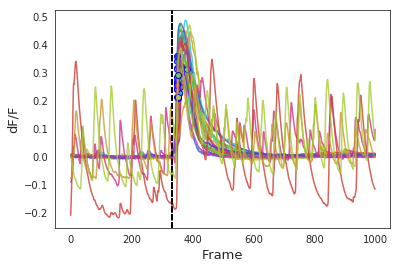

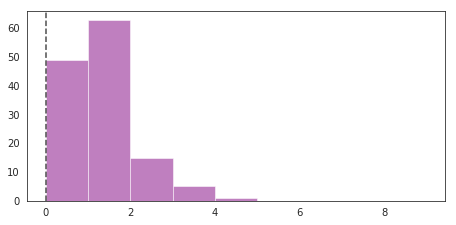

In [26]:

#set stimulation, fps = 16.67
ind63 = []
ind63_seconds = []
stim = 333
for file in results_norm:
    for ex in np.arange(1,len(results_norm[file].columns)-1):
        t_t = stim #don't detect peaks before stim
        series = results_norm[file]['Mean'+str(ex)]
        #window length for HEK = 1min 10s, neurons = 5s
        window_length = 420
        series_peaks =results_norm[file]['Mean'+str(ex)][t_t:window_length]
        if max(series_peaks)>0.2:
            ind = detect_peaks(series_peaks, show=False,mph=0.25, mpd=800, threshold=0, edge='rising',kpsh=False)
            ##calculate rise time
            for index in ind:
                #print(ind)
                Vm_rise63 = (1-(1/exp(1)))*( series[index+t_t]-series[0])
                Vm_rise = Vm_rise63 + series[0]
                data_rise = series[t_t:(index+t_t)] #Vm during rise phase of EJP only
                try:
                    ind_rise = 0 + np.argwhere(data_rise.rolling(window = 1).mean()>Vm_rise)[0]#index of time for 63% change
                    if ind_rise+t_t>stim:
                        ind63.append(int(ind_rise)+t_t)



                except IndexError:
                    continue

                cmap = sns.hls_palette(20,l=.5, s=.6)
                sns.set_palette(cmap)
                #if series[400]>0.1:
                 #   continue
                if  max(series_peaks)>0.3 and max(series_peaks)<0.5 and (ind_rise+t_t)>336:
                    plt.plot(series, alpha = 0.8)
                    plt.axvline(x = 333 , linestyle = '--', color = 'black', alpha =0.7)

                    plt.xlabel("Frame",fontdict={'fontsize':13})
                    plt.ylabel("dF/F",fontdict={'fontsize':13})


                    try:
                            plt.plot(ind_rise+t_t, series[ind_rise++t_t], 'o', mfc=None, mec='b')


                    except KeyError:
                        continue
        else:
            continue
plt.figure(figsize=(7.5, 3.5))
#transformation to present data not relative to stimuli
latency = []
for element in ind63:
            ind63_seconds.append (float(element/16.67))
for element in ind63_seconds:
    latency.append(element-20)
    ,
plt.hist(latency,bins = [0,1,2,3,4,5,6,7,8,9], color = 'purple',alpha = 0.5)
plt.axvline(x = 0 , linestyle = '--', color = 'black', alpha =0.7)




# Width

To calculate the width of the ultrasound induced peak we will calculate time to 63% rise and time to 63% decay and get the interval length.

(array([ 0., 44., 86.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20]),
 <a list of 10 Patch objects>)

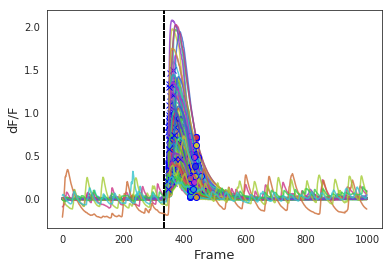

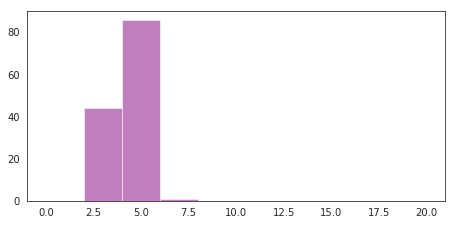

In [29]:
#read csv files generated with ImageJ

from math import exp
#initialize lists to store indexs for 63% rise and 63% decay
ind63_rise = []
ind63_decay = []

#set stimulation 
for file in results_norm:
    for ex in np.arange(1,len(results_norm[file].columns)-1):
        t_t = stim #don't detect peaks before stim
        series = results_norm[file]['Mean'+str(ex)]
        #window length for HEK = 1min 10s, neurons = 5s
        window_length = 420
        series_peaks =results_norm[file]['Mean'+str(ex)][t_t:window_length]
        if max(series_peaks)>0.2:
            ind = detect_peaks(series_peaks, show=False,mph=0.25, mpd=800, threshold=0, edge='rising',kpsh=False)
            ##calculate rise time
            for index in ind:
                index = index + t_t
                Vm_rise63 = (1-(1/exp(1)))*( series[index]-series[0])
                prev = series[332]#value right before stim
                Vm_rise = Vm_rise63 + prev
                data_rise = series[t_t:window_length] #Vm during rise phase of EJP only
                Vm_decay63 = (1-(1/exp(1)))*( series[index]-series[0])
                Vm_decay = series[index] - Vm_decay63
                data_decay = series[window_length:1000] #Vm during decrease phase of EJP only
                try:
                    ind_rise = 0 + np.argwhere(data_rise.rolling(window = 1).mean()>Vm_rise)[0]#index of time for 63% change
                    ind_decay = 0 + np.argwhere(data_decay.rolling(window = 1).mean()<Vm_decay)[0]#index of time for 63% change

                    ind63_rise.append(int(ind_rise)+t_t)
                    ind63_decay.append(int(ind_decay)+window_length)
                except IndexError:
                    continue

                cmap = sns.hls_palette(20,l=.5, s=.6)
                sns.set_palette(cmap)

                plt.plot(series, alpha = 0.8)
                plt.axvline(x = stim , linestyle = '--', color = 'black', alpha =0.7)

                plt.xlabel("Frame",fontdict={'fontsize':13})
                plt.ylabel("dF/F",fontdict={'fontsize':13})


                try:
                        plt.plot(ind_decay+window_length, series[ind_decay+window_length], 'o', mfc=None, mec='b')
                        plt.plot(ind_rise+t_t, series[ind_rise+t_t], 'x', mfc=None, mec='b')
                except KeyError:
                    continue
        else:
            continue
plt.figure(figsize=(7.5, 3.5))

width = []

#transform index data into a width length in seconds
ind63_seconds_decay = []
ind63_seconds_rise = []
for element in ind63_decay:
    ind63_seconds_decay.append (float(element/16.67))
for element in ind63_rise:
    ind63_seconds_rise.append (float(element/16.67))
for i in range(len(ind63_seconds_decay)):


        if ind63_seconds_decay[i]-ind63_seconds_rise[i]<0:
            continue
        else:
            width.append(ind63_seconds_decay[i]-ind63_seconds_rise[i])


plt.hist(width,bins = [0,2,4,6,8,10,12,14,16,18,20], color = 'purple',alpha = 0.5)


